
# Lithium-Ion Battery Modeling using PyBaMM  
## Single Particle Model (SPM) – 1C Discharge Simulation

This notebook demonstrates:

- Running a **1C discharge simulation**
- Using the **Single Particle Model (SPM)**
- Extracting lithium concentration inside the negative particle
- Plotting concentration vs normalized radius
- Evaluating at specific timestamps (0, 900, 1800, 2700, 3600 s)

---

## Physical Background

The SPM assumes each electrode behaves like a single spherical particle.  
Lithium diffusion inside the particle is governed by spherical diffusion:

∂c/∂t = D (1/r²) ∂/∂r ( r² ∂c/∂r )

At higher discharge times, lithium concentration gradients develop between the core and surface.



## 1. Import Required Libraries


In [ ]:
!pip install pybamm
import pybamm
import numpy as np
import matplotlib.pyplot as plt


## 2. Define the SPM Model and 1C Discharge Experiment

We use the instruction:

"Discharge at 1C for 1 hour"


In [26]:

# Create SPM model
model = pybamm.lithium_ion.SPM()

# Define experiment
experiment = pybamm.Experiment(
    ["Discharge at 1C for 1 hour"]
)



## 3. Solve the Simulation

This computes voltage, concentration, and all internal states.


In [27]:
# Run simulation
sim = pybamm.Simulation(model, experiment=experiment)
solution = sim.solve()


## 4. Extract Radial Coordinate and Particle Concentration

We extract:

- Radial coordinate `r_n`
- X-averaged negative particle concentration


In [28]:
# Extract radial coordinate
r_n_mesh = sim.mesh["negative particle"].nodes
r_normalized = r_n_mesh / np.max(r_n_mesh)

# Extract concentration variable
c_s = solution["X-averaged negative particle concentration [mol.m-3]"]


## 5. Plot Lithium Concentration vs Radius

We plot profiles at:

t = 0, 900, 1800, 2700, 3600 seconds


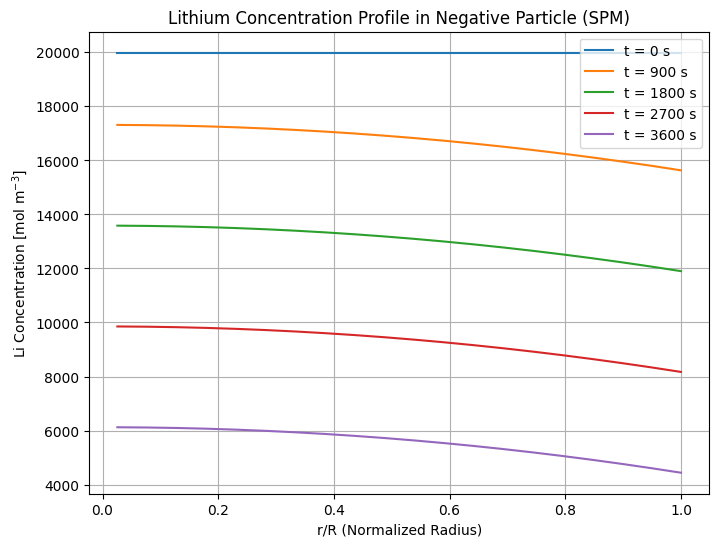

In [29]:

# Time points (seconds)
time_points = [0, 900, 1800, 2700, 3600]

plt.figure(figsize=(8,6))

for t in time_points:
    c_profile = c_s(t)
    plt.plot(r_normalized, c_profile, label=f"t = {t} s")

plt.xlabel("r/R (Normalized Radius)")
plt.ylabel("Li Concentration [mol m$^{-3}$]")
plt.title("Lithium Concentration Profile in Negative Particle (SPM)")
plt.legend()
plt.grid(True)
plt.show()


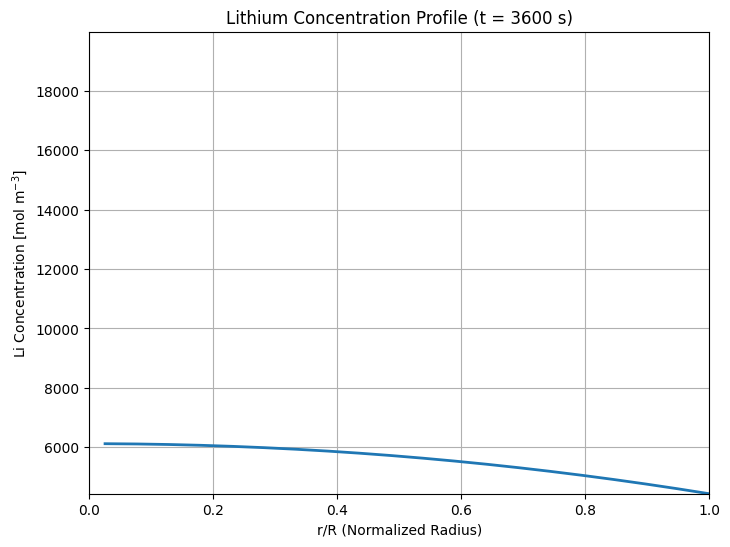

In [30]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Create figure
fig, ax = plt.subplots(figsize=(8,6))

line, = ax.plot([], [], lw=2)

# Axis limits
ax.set_xlim(0, 1)
ax.set_ylim(
    min(c_s(solution.t[-1])),
    max(c_s(0))
)

ax.set_xlabel("r/R (Normalized Radius)")
ax.set_ylabel("Li Concentration [mol m$^{-3}$]")
ax.set_title("Lithium Concentration Profile (SPM, 1C)")
ax.grid(True)

# Initialization function
def init():
    line.set_data([], [])
    return line,

# Update function
def update(frame):
    t = solution.t[frame]
    c_profile = c_s(t)

    line.set_data(r_normalized, c_profile)
    ax.set_title(f"Lithium Concentration Profile (t = {int(t)} s)")

    return line,

# Create animation
ani = FuncAnimation(
    fig,
    update,
    frames=len(solution.t),
    init_func=init,
    blit=True
)

HTML(ani.to_jshtml())

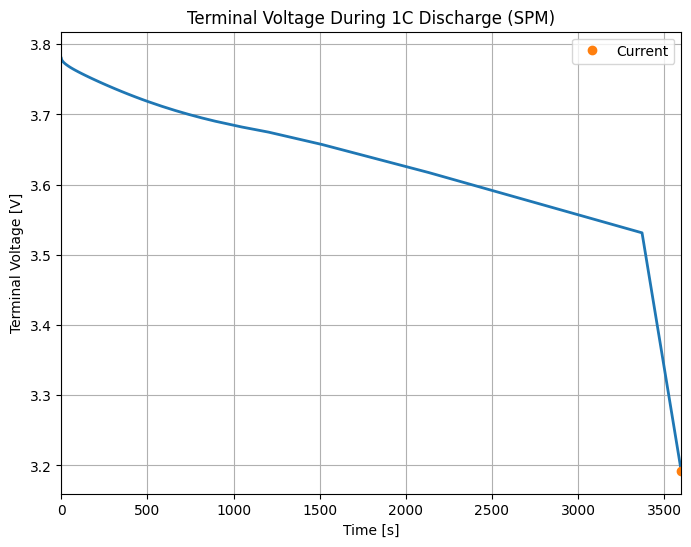

In [31]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
import matplotlib.pyplot as plt

# Extract time and voltage
time = solution["Time [s]"].entries
voltage = solution["Terminal voltage [V]"].entries

# Create figure
fig, ax = plt.subplots(figsize=(8,6))

# Plot full voltage curve (static background)
ax.plot(time, voltage, lw=2)

# Moving marker
point, = ax.plot([], [], 'o', label='Current') # Added label here

ax.set_xlim(0, time[-1])
ax.set_ylim(min(voltage)*0.99, max(voltage)*1.01)

ax.set_xlabel("Time [s]")
ax.set_ylabel("Terminal Voltage [V]")
ax.set_title("Terminal Voltage During 1C Discharge (SPM)")
ax.grid(True)
ax.legend() # Added legend call here

# Initialization
def init():
    point.set_data([], [])
    return point,

# Update function
def update(frame):
    t = time[frame]
    v = voltage[frame]
    point.set_data([t], [v])
    return point,

# Create animation
ani = FuncAnimation(
    fig,
    update,
    frames=len(time),
    init_func=init,
    blit=True
)

HTML(ani.to_jshtml())


## 6. Interpretation of Results

- At **t = 0 s** → uniform concentration (flat profile)
- As discharge progresses → surface concentration decreases
- A radial gradient develops due to diffusion limitation
- At **3600 s** → strongest gradient

This behavior explains voltage drop at higher C-rates.
